In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from sklearn.metrics import r2_score
from importlib import reload
import GR_INV
reload(GR_INV)

<module 'GR_INV' from '/Users/hschumann/Downloads/GR_inversion/GR_INV.py'>

# Synthetic Data for Inversion

## Create synthetic 2-D horizontal well coordinates

In [2]:
hwell_x = np.arange(1,1000,10) # arbitrary well coordinates along horizontal axis
hwell_tvd = np.ones(len(hwell_x))*1000 # arbitrary well coordinates along vertical axis
N = len(hwell_x)
M = len(hwell_tvd)

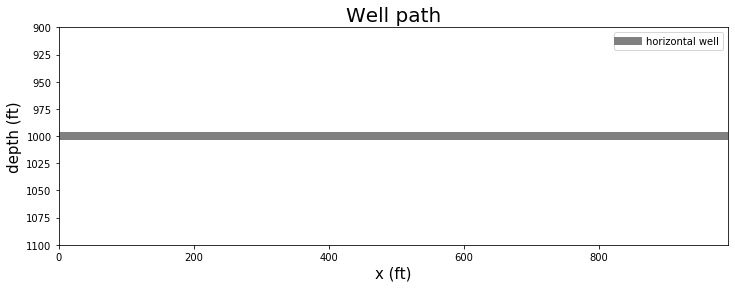

In [3]:
plt.figure(figsize=(12,4))
plt.title('Well path',fontsize=20)
plt.plot(hwell_x,hwell_tvd,'grey',linewidth=8)
plt.xlabel('x (ft)',fontsize=15)
plt.ylabel('depth (ft)',fontsize=15)
plt.legend(['horizontal well'])
plt.ylim([1100,900])
plt.xlim([0,max(hwell_x)])
plt.savefig('Figures/well_path.png')

## Create synthetic pilot well gamma ray log response

In [4]:
pwell_gr = [45,40,45,50,45,30,20,10,40,65,60,50,30] # list of arbitrary gamma ray log responses
pwell_tvd = np.linspace(800,1200,len(pwell_gr)) # corresponding depths for gamma ray 
f = interp1d(pwell_tvd, pwell_gr, kind='cubic') # interpolate arbitrary gamma ray log responses 
pwell_tvd = np.linspace(800, 1200, num=N, endpoint=True)
pwell_gr = f(pwell_tvd)

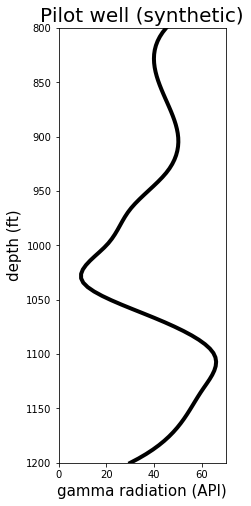

In [5]:
plt.figure(figsize=(3,8))
plt.title('Pilot well (synthetic)',fontsize=20)
plt.plot(pwell_gr,pwell_tvd,'k',linewidth=4)
plt.xlim([0,70])
plt.ylim([max(pwell_tvd),min(pwell_tvd)])
plt.xlabel('gamma radiation (API)',fontsize=15)
plt.ylabel('depth (ft)',fontsize=15)
plt.savefig('Figures/pilot_gr.png')

## Choose reservoir top and bottom depths for pilot well

In [6]:
res_t_tvd_pwell = 950 # reservoir top
res_b_tvd_pwell = 1050 # reservoir bottom
res_thick = res_b_tvd_pwell - res_t_tvd_pwell # reservoir thickness

In [7]:
pwell_res_dist = pwell_tvd-res_t_tvd_pwell # distances along pilot well from reservoir top

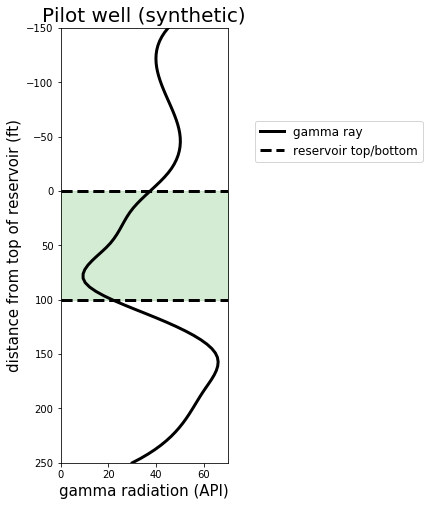

In [8]:
plt.figure(figsize=(3,8))
plt.title('Pilot well (synthetic)',fontsize=20)
plt.plot(pwell_gr,pwell_res_dist,'k',linewidth=3)
plt.xlim([0,70])
plt.ylim([max(pwell_res_dist),min(pwell_res_dist)])
plt.hlines(0,0,70,'k',linestyles='--',linewidth=3)
plt.hlines(res_thick,0,70,'k',linestyles='--',linewidth=3)
plt.fill_between([0,70], [0,0],[res_thick,res_thick],
                 alpha=0.2,color='C2',interpolate=True)
plt.xlabel('gamma radiation (API)',fontsize=15)
plt.ylabel('distance from top of reservoir (ft)',fontsize=15)
plt.legend(['gamma ray','reservoir top/bottom'],loc='upper right',fontsize=12,bbox_to_anchor=(1, 0., 1.2, 0.8))
plt.savefig('Figures/pilot_reservoir.png')

## Create synthetic true reservoir model for horizontal well

In [9]:
res_dip=4 # arbitrary reservoir dip in degrees
res_t_tvd_tvd_hwell = 925 # reservoir top depth at x=0 in coordinate system of the horizontal well

res_t_tvd = np.tan(res_dip*(np.pi/180))*(hwell_x)+res_t_tvd_tvd_hwell # reservoir top depths along horizontal well
res_b_tvd = np.tan(res_dip*(np.pi/180))*(hwell_x)+res_t_tvd_tvd_hwell+res_thick # reservoir bottom depths
z = hwell_tvd - res_t_tvd  # vector of vertical distances from reservoir top to horizontal well

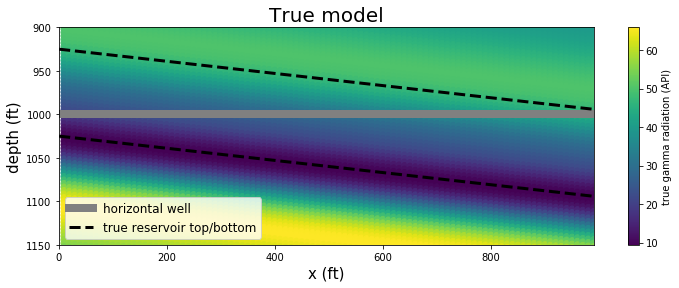

In [10]:
plt.figure(figsize=(12,4))
plt.title('True model',fontsize=20)
plt.plot(hwell_x,hwell_tvd,'grey',linewidth=8)
plt.plot(hwell_x,res_t_tvd,'k--',linewidth=3)
plt.plot(hwell_x,res_b_tvd,'k--',linewidth=3)
plt.xlabel('x (ft)',fontsize=15)
plt.ylabel('depth (ft)',fontsize=15)
plt.ylim([1150,900])
plt.xlim([0,max(hwell_x)])
for i in range(1,len(hwell_x)):
    plt.scatter([i*10]*len(pwell_res_dist),pwell_res_dist+res_t_tvd_pwell+np.tan(res_dip*(np.pi/180))*i*10,c=pwell_gr)
cbar = plt.colorbar()
cbar.set_label('true gamma radiation (API)')
plt.legend(['horizontal well','true reservoir top/bottom'],loc='best',fontsize=12)
plt.savefig('Figures/true_model.png')

## Create initial reservoir model for horizontal well

In [11]:
res_t_tvd_hwell=950 # initial model reservoir top depth

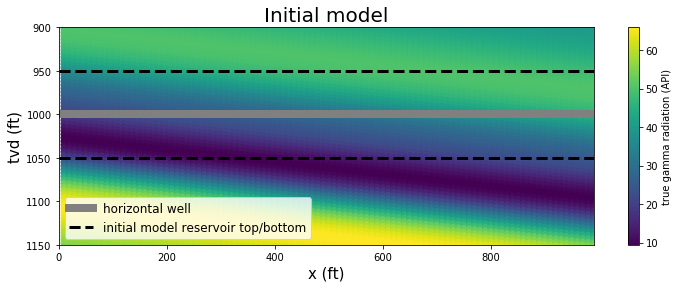

In [12]:
plt.figure(figsize=(12,4))
plt.title('Initial model',fontsize=20)
plt.plot(hwell_x,hwell_tvd,'grey',linewidth=8)
plt.plot(hwell_x,[res_t_tvd_hwell]*len(hwell_x),'k--',linewidth=3)
plt.plot(hwell_x,[res_t_tvd_hwell+res_thick]*len(hwell_x),'k--',linewidth=3)
plt.xlabel('x (ft)',fontsize=15)
plt.ylabel('tvd (ft)',fontsize=15)
plt.ylim([1150,900])
plt.xlim([0,max(hwell_x)])
for i in range(1,len(hwell_x)):
    plt.scatter([i*10]*len(pwell_res_dist),pwell_res_dist+res_t_tvd_pwell+np.tan(res_dip*(np.pi/180))*i*10,c=pwell_gr)
cbar = plt.colorbar()
cbar.set_label('true gamma radiation (API)')
plt.legend(['horizontal well','initial model reservoir top/bottom'],loc='best',fontsize=12)
plt.savefig('Figures/init_model.png')

## Get theoretic horizontal well LWD gamma ray log using pilot well values

In [35]:
GR = GR_INV.GR_Inversion() # class for gamma ray response tikhonov inversion
GR.set_pilot_log_vals(pwell_gr,pwell_tvd,res_t_tvd_pwell) # sets gamma ray, well depths, and reservoir top for pilot
gr_obs_hwell = GR.get_GR_response(z) # returns true gamma ray log response for horizontal well
gr_obs_hwell += np.random.normal(loc=0.0, scale=2.0, size=N) # add Gaussian noise to gamma ray log response

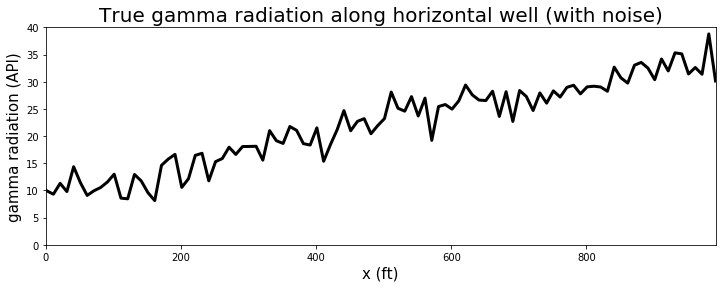

In [36]:
plt.figure(figsize=(12,4))
plt.title('True gamma radiation along horizontal well (with noise)',fontsize=20)
plt.plot(hwell_x,gr_obs_hwell,'k',linewidth=3)
plt.xlim([0,max(hwell_x)])
plt.ylim([0,40])
plt.ylabel('gamma radiation (API)',fontsize=15)
plt.xlabel('x (ft)',fontsize=15)
plt.savefig('Figures/gr_obs.png')

# Perform inversion using Tikhonov regularization

## Get Jacobian matrix

In [37]:
dz=4 # model perturbation amount
GR.get_jacobian(res_t_tvd_hwell,hwell_tvd,dz) # find Jacobian matrix

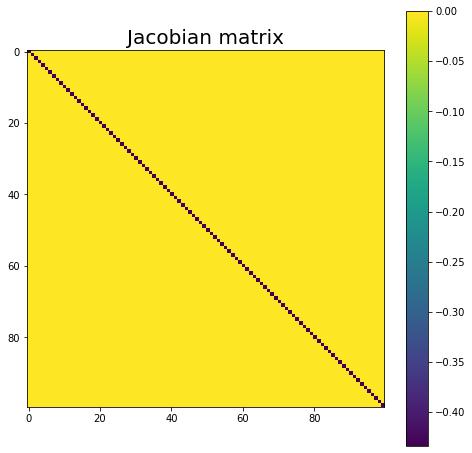

In [38]:
plt.figure(figsize=(8,8))
plt.title('Jacobian matrix',fontsize=20)
plt.imshow(GR.J)
plt.colorbar()
plt.savefig('Figures/jacobian.png')

## Perform inversion for smallest, flattest model

In [39]:
dh_pred, gr_pred = GR.tikhonov(gr_obs_hwell,hwell_x,beta=10**-7) # inversion for smallest, flattest model

## Visualize output

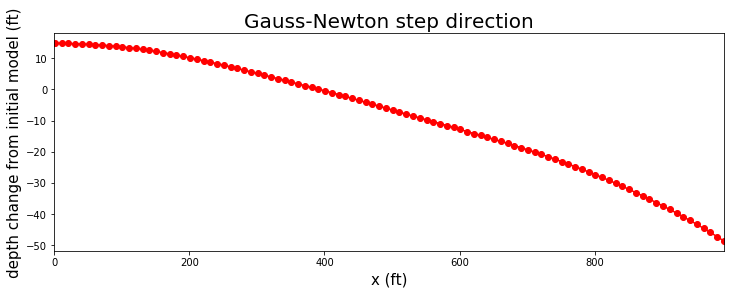

In [40]:
plt.figure(figsize=(12,4))
plt.title("Gauss-Newton step direction",fontsize=20)
plt.plot(hwell_x,dh_pred,'r-o')
plt.ylabel('depth change from initial model (ft)',fontsize=15)
plt.xlabel('x (ft)',fontsize=15)
plt.xlim([0,max(hwell_x)])
plt.savefig('Figures/step_direction.png')

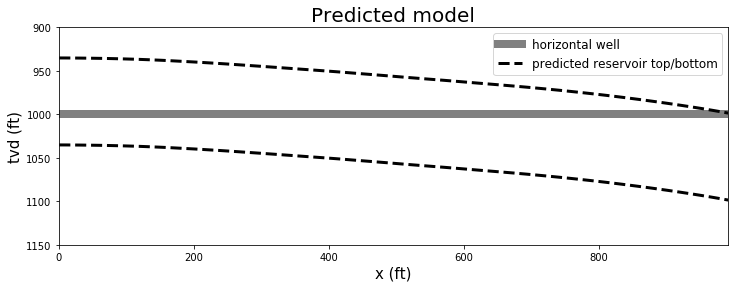

In [41]:
plt.figure(figsize=(12,4))
plt.title('Predicted model',fontsize=20)
plt.plot(hwell_x,hwell_tvd,'grey',linewidth=8)
plt.plot(hwell_x,-dh_pred+res_t_tvd_hwell,'k--',linewidth=3)
plt.plot(hwell_x,-dh_pred+res_t_tvd_hwell+res_thick,'k--',linewidth=3)
plt.legend(['horizontal well','predicted reservoir top/bottom'],loc='best',fontsize=12)
plt.xlabel('x (ft)',fontsize=15)
plt.ylabel('tvd (ft)',fontsize=15)
plt.ylim([1150,900])
plt.xlim([0,max(hwell_x)])
plt.savefig('Figures/pred_model.png')

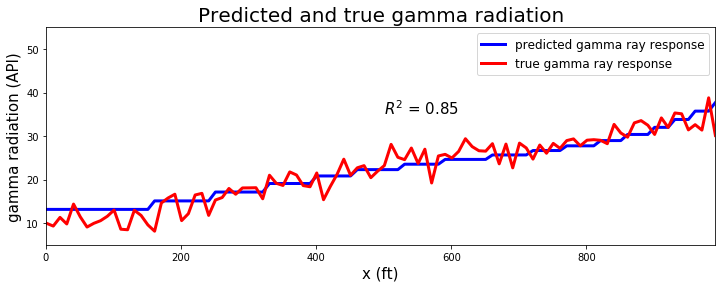

In [42]:
plt.figure(figsize=(12,4))
plt.title("Predicted and true gamma radiation",fontsize=20)
plt.plot(hwell_x,gr_pred,'b-',linewidth=3)
plt.plot(hwell_x,gr_obs_hwell,'r-',linewidth=3)
plt.ylabel('gamma radiation (API)',fontsize=15)
plt.xlabel('x (ft)',fontsize=15)
plt.text(500,35,'$R^{2}$ = '+str(round(r2_score(gr_pred,gr_obs_hwell),3)),fontsize=15)
plt.xlim([0,max(hwell_x)])
plt.ylim([5,55])
plt.legend(['predicted gamma ray response','true gamma ray response'],loc='best',fontsize=12)
plt.savefig('Figures/pred_gr.png')

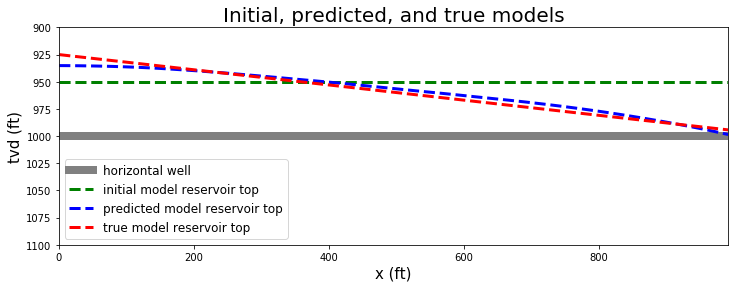

In [43]:
plt.figure(figsize=(12,4))
plt.title('Initial, predicted, and true models',fontsize=20)
plt.plot(hwell_x,hwell_tvd,'grey',linewidth=8)
plt.plot(hwell_x,[res_t_tvd_hwell]*N,'g--',linewidth=3)
plt.plot(hwell_x,-dh_pred+res_t_tvd_hwell,'b--',linewidth=3)
plt.plot(hwell_x,res_t_tvd,'r--',linewidth=3)
plt.legend(['horizontal well','initial model reservoir top',
            'predicted model reservoir top',
            'true model reservoir top'],
            loc='best',fontsize=12)
plt.xlabel('x (ft)',fontsize=15)
plt.ylabel('tvd (ft)',fontsize=15)
plt.ylim([1100,900])
plt.xlim([0,max(hwell_x)])
plt.savefig('Figures/model_comparison.png')

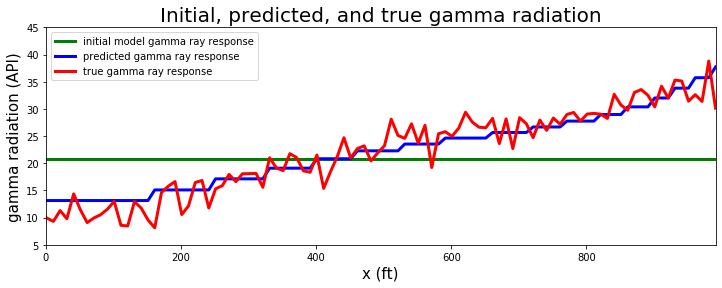

In [44]:
plt.figure(figsize=(12,4))
plt.title("Initial, predicted, and true gamma radiation",fontsize=20)
plt.plot(hwell_x,GR.get_GR_response(hwell_tvd-[res_t_tvd_hwell]*N),'g-',linewidth=3)
plt.plot(hwell_x,gr_pred,'b-',linewidth=3)
plt.plot(hwell_x,gr_obs_hwell,'r-',linewidth=3)

plt.ylabel('gamma radiation (API)',fontsize=15)
plt.xlabel('x (ft)',fontsize=15)
plt.xlim([0,max(hwell_x)])
plt.ylim([5,45])
plt.legend(['initial model gamma ray response','predicted gamma ray response','true gamma ray response'],loc='best')
plt.savefig('Figures/gr_comparison.png')